# Leak Location Optimization
### Import Necessary Libraries

In [1]:
import matplotlib.pyplot as plt 
import pandas as pd
import numpy as np
import pygad
import numpy
import glob
import wntr
import os

In [2]:
import warnings
warnings.filterwarnings('ignore')

In [3]:
class Config:
    num_generations =100 #Number of generations.
    num_parents_mating = 1 # Number of solutions to be selected as parents in the mating pool.
    sol_per_pop = 20 # Number of solutions in the population.
    num_genes = 1 #len(function_inputs) --> this can be an array
    init_range_low = 0
    init_range_high = 1
    parent_selection_type = "sss" # Type of parent selection.
    keep_parents = -1 # Number of parents to keep in the next population. -1 means keep all parents and 0 means keep nothing.
    crossover_type = "single_point" # Type of the crossover operator. 
    mutation_type = "random" # Type of the mutation operator.
    mutation_num_genes=1 # Type of the mutation operator.
    last_fitness = 0
    
    INP_FILE_PATH = r"../data/Real_Synthetic_Net.inp" 
    TEMP_DIR = "../temp/"
    PLOTS_DIR = "../plots"
    FUNCTION_INPUTS = None
    DESIRED_OUTPUT = None

In [4]:
class WaterLeakModel(Config):
    
    def __init__(self, node:str):
        ''' 
            node: node/junction ID in the network
        '''
        self.node = node
        
        # Check if node is junction_name 
        wn = wntr.network.WaterNetworkModel(self.INP_FILE_PATH)
        assert wn.junction_name_list.count(node) == 1, "Node not found in the network"
        self.node_index = wn.junction_name_list.index(node)
    
    def simulate(self, wn, plot_graph=True):
        """
        If plot_graph is set to true, a graph of the network is plotted after simulation
        """
        # Plot pressure after add leak to node
            
        sim = wntr.sim.WNTRSimulator(wn)
        results = sim.run_sim()
        pressure = results.node['pressure']
        pressure_at_N6 = pressure.loc[:,wn.junction_name_list[self.node_index]]
        if plot_graph:
            wntr.graphics.plot_network(wn, node_attribute=pressure.any(), node_size=150, title='Pressure at 0 hours')
        
        return results
    
    def change_discharge_coefficient(self, wn, emitter_value):
        """
        This function changes the emitter coefficient for selected node in the network, and create a 
        structured representation of our data, a csv.
        
        parameters
        ----------
        emitter_value: the emitter coefficient value
        """

        node = wn.get_node(str(self.node))
        node.add_leak(wn, area=0.00015, start_time=0, end_time=1, discharge_coeff=emitter_value)
        return self.simulate(wn, plot_graph=False)
    
    def export_results(self, solutions:list, path:str, name:str):
        """
        Concatenates all solutions generated and exports as a single csv file
        
        parameters
        ----------
        solution: a list of all paths to the solutions csv files
        path: path where concatenated solution will be exported to
        name: name to be assigned to exported file
        """
        if not os.path.exists(path):
            os.mkdir(path)
        
        temp = pd.DataFrame()
        for i in range(len(solutions)):
            data = pd.read_csv(solutions[i])
            if i == 0:
                temp = data
            else:
                temp = pd.concat([temp, data])
        name+=".csv"
        try:
            temp.to_csv(os.path.join(path,name),index=False)
            print(f'File Exported Successfully to path: {os.path.join(path, name)}')
        except Exception as e:
            print(e)
        

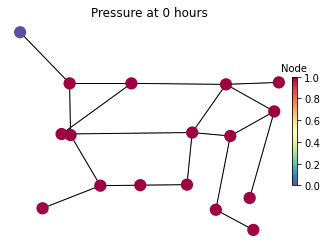

In [5]:
# Instantiate the pygad optimization class
config = Config()
water_model = WaterLeakModel(node='N6')
config.num_generations = 100

# Add leak and simulate
wn = wntr.network.WaterNetworkModel(config.INP_FILE_PATH)
node = wn.get_node('N6')
node.add_leak(wn, area=0.00015, start_time=0, end_time=1, discharge_coeff=.5)
water_model.simulate(wn, plot_graph=True)

config.FUNCTION_INPUTS = 0.5
config.DESIRED_OUTPUT = node.head - node.elevation

In [6]:
def fitness_function(solution, solution_idx):
        
    wn = wntr.network.WaterNetworkModel(config.INP_FILE_PATH)
    results = water_model.change_discharge_coefficient(wn, emitter_value=abs(solution[0])) #change emitter coefficient

    pressure = results.node['pressure']
    output = pressure.loc[:,'N6']
    demands=results.node['demand']
    output_demand = demands.loc[:,'N6']

    fitness = 1.0 / (np.abs(output - config.DESIRED_OUTPUT) + 0.000001)

    # Structure and export the output of the fitness
    data = pd.DataFrame(columns=['EMITTER_COEFFICIENT_SOLUTION','OUTPUT','OUTPUT_DEMAND','FITNESS'])
    data = data.append({'EMITTER_COEFFICIENT_SOLUTION':abs(solution[0]),'OUTPUT':list(output)[0],'FITNESS':list(fitness)[0],'OUTPUT_DEMAND':(list(output_demand) [0]*1000)},ignore_index=True)
    data.to_csv(f"{config.TEMP_DIR}/FITNESS_SOLUTION_{str(abs(solution[0]))}.csv",index=False) 

    print('=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========')
    print ('======|', abs(round(solution[0],3)),'|===========|',list(round(output,3))[0],'|==================|',list(round(fitness, 3))[0],'|==========')
    print('================================='*2)

    return list(fitness)[0]

In [7]:
#################### Create a Callback Function ########################
last_fitness = 0
def callback_generation(ga_instance): # This function prints algorithm progress
    global last_fitness
    print("Generation = {generation}".format(generation=ga_instance.generations_completed)) 
    print("Fitness = {fitness}".format(fitness=ga_instance.best_solution()[1]))
    print("Change = {change}".format(change=ga_instance.best_solution()[1] - last_fitness)) 

    data =pd.DataFrame(columns=['GENERATION','FITNESS'])
    data =data.append({'GENERATION':ga_instance.generations_completed,'FITNESS': ga_instance.best_solution ()[1]},ignore_index=True)
    data.to_csv(f"{config.TEMP_DIR}/GENERATION_{str(ga_instance.generations_completed)}.csv",index=False) 
    last_fitness = ga_instance.best_solution()[1]

In [8]:
# Instantiate the pygad optimization class
ga_instance = pygad.GA(num_generations=config.num_generations,
                       num_parents_mating=config.num_parents_mating, 
                       fitness_func=fitness_function, 
                       sol_per_pop=config.sol_per_pop,
                       num_genes=config.num_genes,
                       init_range_low=config.init_range_low,
                       init_range_high=config.init_range_high,
                       parent_selection_type=config.parent_selection_type,
                       keep_parents=config.keep_parents,
                       crossover_type=config.crossover_type,
                       mutation_type=config.mutation_type,
                       mutation_num_genes=config.mutation_num_genes,
                       callback_generation=callback_generation)

In [9]:
# ga_instance.run()

In [10]:
# ga_instance.plot_result()

In [11]:
# # Check the model's prediction
# prediction = numpy.sum(numpy.array(config.FUNCTION_INPUTS)*solution)
# print("Predicted output based on the best solution :{prediction}".format(prediction=prediction))

# if ga_instance.best_solution_generation != -1:
#     print("Best fitness value reached after {best_solution_generation} generations.".format(best_solution_generation=ga_instance.best_solution_generation))


> **The node with the highest fitness is considered to have a leak.**

In [12]:
water_model = WaterLeakModel(node='N6')
config = Config()

In [13]:
node = wn.get_node('N6')
sim = wntr.sim.WNTRSimulator(wn)
results = sim.run_sim()

desired_output = node.head-node.elevation 
function_input = 1
all_nodes = wn.junction_name_list

In [14]:
df=pd.DataFrame(columns=['NODE','EMITTER_COEFFICIENT','OUTPUT','FITNESS']) 
for i in range(len(all_nodes)):
    wn = wntr.network.WaterNetworkModel(config.INP_FILE_PATH)
    water_model = WaterLeakModel(node=wn.junction_name_list[i])
    results = water_model.change_discharge_coefficient(wn, emitter_value=function_input)
    pressure = results.node['pressure']
    output = pressure.loc[:,'N6']
    fitness = 1.0 / (np.abs(output - desired_output) + 0.000001)
    
    df=df.append({'NODE':all_nodes[i],'EMITTER_COEFFICIENT':function_input,'OUTPUT':list(output)[0],'FITNESS':list(fitness)[0]},ignore_index=True)
    df=df.sort_values(by='FITNESS',ascending=False)
    df=df.reset_index(drop=True)

In [15]:
df

,NODE,EMITTER_COEFFICIENT,OUTPUT,FITNESS
0,N1,1,26.586528,31.834066
1,N5,1,26.537188,12.383472
2,N11,1,26.532713,11.733322
3,N15,1,26.529369,11.290347
4,N10,1,26.529244,11.274347
5,N2,1,26.525863,10.860365
6,N3,1,26.512574,9.490660
7,N4,1,26.510693,9.324200
8,N14,1,26.500303,8.500680
9,N9,1,26.496327,8.222758


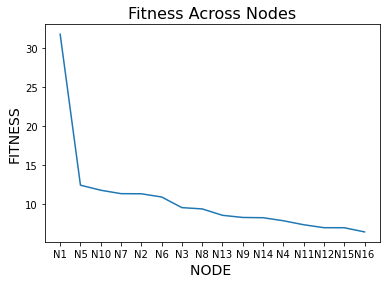

In [19]:
x=list(range(1,len(df)+1))
plt.plot(x,df['FITNESS'])

plt.xlabel('NODE ',fontsize=14)
plt.ylabel('FITNESS',fontsize=14)
plt.xticks(x,all_nodes)

plt.title('Fitness Across Nodes',fontsize=16)
plt.savefig(f"{config.TEMP_DIR}/node_fitness.png")